# Tutorial 2.b: Learning Calibrated Probabilities: The Basics

Calibration is a basic requirement for probabilistic predictions. However, many classification models are not intrinsically well-calibrated. Thus, there exist several methods that apply a post-processing adjustment to the classifier to improve the model's calibration. In this tutorial we will cover some basic recalibration techniques. 

<!-- Recalibration methods are a set of post-processing techniques for adjusting predicted probabilities to make them better calibrated. -->

In [1]:
# We must first import the dependencies, and make sure that the torchuq package is in PYTHONPATH
# If you are running this notebook in the original directory as in the repo, then the following statement should work
import sys
sys.path.append('../..')   # Include the directory that contains the torchuq package
import torch  
from matplotlib import pyplot as plt

In [2]:
reader = torch.load('pretrained/resnet18-cifar10.pt')
predictions = reader['categorical']
labels = reader['labels']

Most calibration algorithms are in the ```torchuq.transform.calibrate``` module, with the exception of decision calibration, which is in the ```torchuq.transform.decision``` module. 

In [3]:
from torchuq.evaluate import categorical
from torchuq.transform.calibrate import *

Torchuq implements many recalibration algorithms. Below is a list of currently supported algorithms:

- Standard calibration methods: temperature scaling, histogram binning 
- Classwise calibration methods: dirichlet recalibration
- Advanced calibration methods: Decision calibration 

## Standard Calibration Methods

### Temperature Scaling 

Temperature scaling is a recalibration method for neural networks that learns a single temperature parameter and rescales the confidence scores for all samples simultaneously. 

For each input $x$, a neural network typically first computes a logit score $l_1(x), \dots, l_n$ for each of the $n$ possible classes. It then applies a softmax function to compute the confidence score:

$$ \hat{p}(x) = \max_i \frac{e^{l_i(x)}}{\sum_j e^{l_j(x)}} $$ 

Temperature scaling simply adds a temperature parameter $T$ to the softmax function: 

$$ \hat{p}(x, T) = \max_i \frac{e^{l_i(x)/T}}{\sum_j e^{l_j(x)/T}} $$ 

A higher temperature ($T>1$) will reduce the confidence, and a lower temperature ($T<1$) will increase the confidence. $T$ is trained to minimize the standard cross entropy loss on a validation dataset. Note that the *accuracy* of the classifier will not change --- the relative ordering of the $n$ possible classes will remain the same, so the predicted class will remain the same. Only the *confidence* of the predicted class will change. 

Despite its simplicity, temperature scaling performs well empirically in classification calibration for deep neural networks [1]. 

In torchuq, all calibrator classes work in essentially the same way, so this may sound familiar if you have seen the tutorial for regression. In particular, to use ``TemperatureScaling`` there are only three functions that you need to know: 

1. Constructor: ``calibrator = TemperatureScaling``. 

2. Train: ``TemperatureScaling.train(val_preds, val_labels)`` trains the predictor based on validation predictions and validation labels

3. Test: ``test_intervals = TemperatureScaling(test_preds)`` outputs the recalibrated predictions

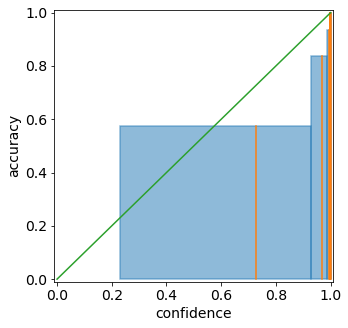

In [4]:
categorical.plot_reliability_diagram(predictions, labels);

In [5]:
calibrator = TemperatureScaling(verbose=True)
calibrator.train(predictions, labels)
predictions_ts = calibrator(predictions)

_change_device is deprecated 
Iteration 0, lr=0.00100, NLL=0.178
Iteration 100, lr=0.00100, NLL=0.170
Iteration 200, lr=0.00100, NLL=0.165
Iteration 300, lr=0.00100, NLL=0.163
Iteration 400, lr=0.00100, NLL=0.162
Iteration 500, lr=0.00100, NLL=0.162
Iteration 600, lr=0.00100, NLL=0.162
Iteration 700, lr=0.00050, NLL=0.162
_change_device is deprecated 


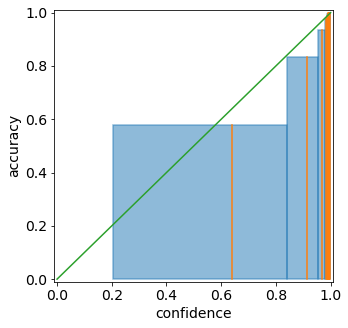

In [6]:
categorical.plot_reliability_diagram(predictions_ts, labels);

### Histogram Binning 

Histogram binning is another popular recalibration method for classification models. Histogram binning partitions the confidence scores into bins $\{[0, \epsilon), [\epsilon, 2\epsilon), \cdots, [1-\epsilon, 1] \}$, and sorts each validation sample into a bin based on its predicted confidence. It then resets the confidence score for each element in a bin to match the average classification accuracy of elements in that bin. 

With torchuq, it is extremely easy to use a different recalibration method --- simply replace the TemperatureScaling class with the HistogramBinning class. In this case, histogram binning appears to achieve better calibration than temeprature scaling, as shown in the visualized reliability diagram. 

Top-1 accuracy of predictor is 0.952
Number of histogram binning bins is 20
tensor([-1.0000,  0.8616,  0.9733,  0.9918,  0.9962,  0.9977,  0.9983,  0.9986,
         0.9988,  0.9990,  0.9991,  0.9992,  0.9992,  0.9993,  0.9994,  0.9994,
         0.9995,  0.9996,  0.9996,  0.9997,  2.0000])


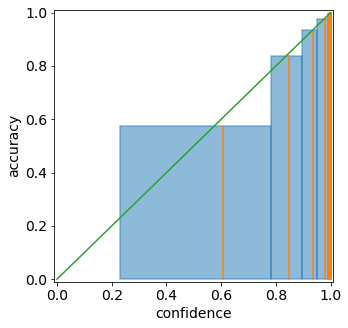

In [7]:
calibrator = HistogramBinning(verbose=True)
calibrator.train(predictions, labels)
predictions_hb = calibrator(predictions)
categorical.plot_reliability_diagram(predictions_hb, labels);

## Classwise Calibration Methods

Sometimes, overall confidence calibration is insufficient. In many applications, we may instead want to achieve the stronger notion of *classwise* calibration. Classwise calibration groups samples by their true class label, and considers the ECE within each class; this may be useful (for instance) for ensuring that different groups are similarly well calibrated. 

### Dirichlet Calibration 

One method for achieving classwise calibration is Dirichlet calibration [2]. This method learns a calibration map that transforms the predicted probabilities based on a Dirichlet probability distribution. In neural networks, it can be implemented as additional layers: a logarithmic transformation followed by a fully connected layer with softmax activation. 

_change_device is deprecated 
Finished training 0 epochs, lr=0.00100, nll = 4.563, reg = 3.135
Finished training 10 epochs, lr=0.00100, nll = 0.457, reg = 2.039
Finished training 20 epochs, lr=0.00100, nll = 0.231, reg = 1.139
Finished training 30 epochs, lr=0.00100, nll = 0.187, reg = 0.574
Finished training 40 epochs, lr=0.00100, nll = 0.170, reg = 0.287
Finished training 50 epochs, lr=0.00100, nll = 0.162, reg = 0.145
Finished training 60 epochs, lr=0.00100, nll = 0.158, reg = 0.083
Finished training 70 epochs, lr=0.00100, nll = 0.155, reg = 0.051
Finished training 80 epochs, lr=0.00100, nll = 0.154, reg = 0.043
Finished training 90 epochs, lr=0.00100, nll = 0.152, reg = 0.039
Finished training 100 epochs, lr=0.00100, nll = 0.151, reg = 0.039
Finished training 110 epochs, lr=0.00050, nll = 0.150, reg = 0.042
Finished training 120 epochs, lr=0.00013, nll = 0.150, reg = 0.043
Finished training 130 epochs, lr=0.00006, nll = 0.150, reg = 0.042
Finished training 140 epochs, lr=0.00003, n

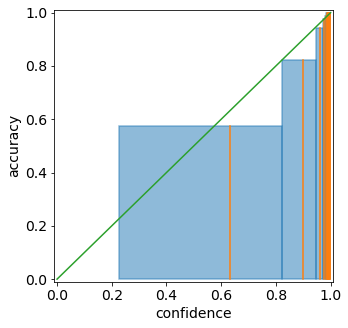

In [8]:
calibrator = DirichletCalibrator(verbose=True)
calibrator.train(predictions, labels)
predictions_dc = calibrator(predictions)
categorical.plot_reliability_diagram(predictions_dc, labels);

## Advanced Calibration Methods

### Decision Calibration

[TBD]

# References

[1] Chuan Guo, Geoff Pleiss, Yu Sun, and Kilian Weinberger. "On Calibration of Modern Neural Networks." International Conference on Machine Learning (2017). 

[2] Meelis Kull, Miquel Perello-Nieto, Markus Kängsepp, Telmo Silva Filho, Hao Song, and Peter Flach. "Beyond temperature scaling: Obtaining well-calibrated multiclass probabilities with Dirichlet calibration." NeurIPS (2019).
